# Implementation of SimCLR with training the encoder and after the classification head

**The encoder can be pretrained using an unsupervised way. It is after trained using the SimCLR algorithm and the classification head is trained by supervised learning**

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPU devices
os.environ["TFDS_DATA_DIR"] = os.path.expanduser("~/tensorflow_datasets")  # default location of tfds database
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers, models, regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import tensorflow as tf
import tensorflow_datasets as tfds

from pathlib import Path

import matplotlib.pyplot as plt

# Turn off logging for TF
import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.get_logger().setLevel(logging.ERROR)

from dpmhm.datasets import preprocessing, feature, utils, transformer, query_parameters

2024-07-02 14:56:37.215196: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-02 14:56:37.220766: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-02 14:56:37.283591: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-02 14:56:38.345609: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
nb_elem_dirg=10000
nb_elem_paderborn= 10000
ds_train_size = nb_elem_dirg+nb_elem_paderborn

batch_size = 64
n_embedding  = 256 
kernel_size = (3,3) 
tau = 0.1
projection_dim = 128 

# Preprocessing on data

In [3]:
outdir = Path('/volatile/home/bm279471/tmp/meta_dataset')
os.makedirs(outdir, exist_ok=True)

In [4]:
# def pipeline(ds_name:str, *, split:str='all', channels:list=[], keys:list=None):
#     """Pipeline of preprocessing.

#     Parameters
#     ----------
#     ds_name
#         name of the dataset
#     split, optional
#         split to load, by default 'all'
#     channels, optional
#         channels to load, by default load all channels simultaneously
#     keys, optional
#         keys for the ramnification of labels

#     """
#     ds0 = tfds.load(ds_name, split=split)
#     if keys is None:
#         keys = query_parameters(ds_name)['keys'].keys()

#     compactor = transformer.DatasetCompactor(
#         ds0,
#         channels=channels, # select all channels simultaneously
#         keys=keys,
#         # resampling_rate=12000,
#         # split_channel=True,  # split multidimensional signals into 1d signals, incompatible with the pretrained VGGish model
#     )

#     _func = lambda x, sr: feature.spectral_features(
#         x, sr, 'spectrogram',
#         # n_mfcc=256,
#         time_window=0.025, hop_step=0.0125,
#         # n_fft=512,
#         normalize=False, to_db=True)[0]

#     extractor = transformer.FeatureExtractor(compactor.dataset, _func)

#     window = transformer.WindowSlider(extractor.dataset, window_size=(64,64), hop_size=(32,32))

#     labels = list(compactor.full_label_dict.keys())  # need the whole list of labels

#     return window.dataset, labels

# ds_list = ['CWRU', 'DIRG', 'Paderborn']
# ds_all = {}

# ds_all['CWRU'] = pipeline('CWRU')
# ds_all['DIRG'] = pipeline('DIRG', split='variation', channels=['A1'])
# ds_all['Paderborn'] = pipeline('Paderborn', split='healthy[:25%]+artificial[:25%]', channels=['vibration', 'current'])

# ds1, ds2, ds3 = ds_all['CWRU'][0], ds_all['DIRG'][0], ds_all['Paderborn'][0]
# lb1, lb2, lb3 = ds_all['CWRU'][1], ds_all['DIRG'][1], ds_all['Paderborn'][1]
# print(ds1.element_spec)
# print(ds2.element_spec)
# print(ds3.element_spec)

# ds2=ds2.take(nb_elem_dirg)
# ds3=ds3.take(nb_elem_paderborn)
# ds_train = ds2.concatenate(ds3)

# preproc_train = preprocessing.get_mapping_supervised(lb2+lb3)
# preproc_test = preprocessing.get_mapping_supervised(lb1)

# ds_train = utils.restore_shape(
#     ds_train.map(preproc_train, num_parallel_calls=tf.data.AUTOTUNE))
# ds_test = utils.restore_shape(
#     ds1.map(preproc_test, num_parallel_calls=tf.data.AUTOTUNE))

# eles = list(ds_train.take(10).as_numpy_iterator())
# input_shape = eles[0][0].shape

# ds_train = ds_train.map(lambda x,y: (tf.ensure_shape(x, input_shape), y), num_parallel_calls=tf.data.AUTOTUNE)
# ds_test = ds_test.map(lambda x,y: (tf.ensure_shape(x, input_shape), y), num_parallel_calls=tf.data.AUTOTUNE)

# ds_train=ds_train.map(lambda x, y: (layers.Rescaling(2/(tf.reduce_max(x)-tf.reduce_min(x)), offset=1-tf.reduce_max(x)*2/(tf.reduce_max(x)-tf.reduce_min(x)))(x), y))
# split_train = {'train':0.8, 'val':0.2}
# ds_split_train = utils.split_dataset(ds_train, split_train)

# ds_test=ds_test.map(lambda x, y: (layers.Rescaling(2/(tf.reduce_max(x)-tf.reduce_min(x)), offset=1-tf.reduce_max(x)*2/(tf.reduce_max(x)-tf.reduce_min(x)))(x), y))
# split_test = {'fine-tuning':0.1,'val':0.05, 'test':0.85}
# ds_split_test = utils.split_dataset(ds_test, split_test,labels=[i+1 for i in range(len(lb1))])

# import json

# ds_split_train['train'].save(str(outdir/'ds_train'))
# ds_split_train['val'].save(str(outdir/'ds_val'))
# ds_split_test['fine-tuning'].save(str(outdir/'ds_train_ft'))
# ds_split_test['val'].save(str(outdir/'ds_val_ft'))
# ds_split_test['test'].save(str(outdir/'ds_test_ft'))

# with open(outdir/'lb1.json', 'w') as fp:
#     json.dump(lb1,fp)
# with open(outdir/'lb2.json', 'w') as fp:
#     json.dump(lb2,fp)
# with open(outdir/'lb3.json', 'w') as fp:
#     json.dump(lb3,fp)

In [5]:
import json

ds_train = tf.data.Dataset.load(str(outdir/'ds_train'))
ds_val = tf.data.Dataset.load(str(outdir/'ds_val'))
ds_train_ft = tf.data.Dataset.load(str(outdir/'ds_train_ft'))
ds_val_ft = tf.data.Dataset.load(str(outdir/'ds_val_ft'))
ds_test_ft = tf.data.Dataset.load(str(outdir/'ds_test_ft'))

with open(outdir/'lb1.json', 'r') as fp:
    lb1 = list(json.load(fp))
with open(outdir/'lb2.json', 'r') as fp:
    lb2 = list(json.load(fp))
with open(outdir/'lb3.json', 'r') as fp:
    lb3 = list(json.load(fp))

ds_train_clr = ds_train.map(lambda x,l:(x,x)).shuffle(ds_train_size, reshuffle_each_iteration=False).cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_val_clr = ds_val.cache().batch(batch_size,drop_remainder=True)

ds_train_class = ds_train.shuffle(ds_train_size, reshuffle_each_iteration=False).cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_val_class = ds_val.cache().batch(batch_size,drop_remainder=True)

ds_test_size = utils.get_dataset_size(ds_train_ft)+utils.get_dataset_size(ds_val_ft)+utils.get_dataset_size(ds_test_ft)

ds_train_ft= ds_train_ft.shuffle(ds_test_size, reshuffle_each_iteration=False).cache().batch(batch_size,drop_remainder=True).prefetch(tf.data.AUTOTUNE)
ds_val_ft = ds_val_ft.cache().batch(batch_size,drop_remainder=True)
ds_test_ft=ds_test_ft.cache().batch(1)

2024-07-02 14:56:40.830021: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-07-02 14:56:40.830061: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: is230816
2024-07-02 14:56:40.830078: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: is230816
2024-07-02 14:56:40.830196: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 535.183.1
2024-07-02 14:56:40.830237: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 535.183.1
2024-07-02 14:56:40.830262: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 535.183.1
2024-07-02 14:56:41.399224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RA

In [6]:
ds_test_size = utils.get_dataset_size(ds_train_ft)+utils.get_dataset_size(ds_val_ft)+utils.get_dataset_size(ds_test_ft)
eles = list(ds_train_clr.take(1).as_numpy_iterator())
input_shape = eles[0][0][0].shape
print(input_shape)

2024-07-02 14:56:45.513861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-02 14:56:45.611687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-02 14:56:49.652874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(64, 64, 3)


2024-07-02 14:56:51.133135: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-07-02 14:56:51.138416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# With an encoder from scratch

**Autoencoder**

Create the autoencoder

In [7]:
@tf.keras.utils.register_keras_serializable()
class Encoder(models.Model):
    """Convolution Auto-Encoder stacks.

    Notes
    -----
    Shape (H,W) of the input tensor must be power of 2.
    """
    def __init__(self, input_shape, n_embedding, kernel_size):
        super(Encoder, self).__init__()
        activation = 'relu'
        padding = 'same'
        strides = (2, 2)
        pool_size = (2, 2)
        a_reg = 0.

        # Encoder
        input_enc = layers.Input(shape=input_shape, name='input_enc')
        x = layers.Conv2D(32, kernel_size=kernel_size, activation=activation, padding=padding, name='conv1_enc')(input_enc)
        x = layers.MaxPooling2D(pool_size=pool_size, strides=strides, name='pool1_enc')(x)
        x = layers.BatchNormalization(name='bn1_enc')(x)

        x = layers.Conv2D(64, kernel_size=kernel_size, activation=activation, padding=padding, name='conv2_enc')(x)
        x = layers.MaxPooling2D(pool_size=pool_size, strides=strides, name='pool2_enc')(x)
        x = layers.BatchNormalization(name='bn2_enc')(x)

        x = layers.Conv2D(128, kernel_size=kernel_size, activation=activation, padding=padding, name='conv3_enc')(x)
        x = layers.MaxPooling2D(pool_size=pool_size, strides=strides, name='pool3_enc')(x)
        x = layers.BatchNormalization(name='bn3_enc')(x)

        x = layers.Flatten(name='flatten')(x)
        if a_reg > 0:
            x = layers.Dense(n_embedding, activation=activation, activity_regularizer=regularizers.L1(a_reg), name='fc1_enc')(x)
        else:
            x = layers.Dense(n_embedding, activation=activation, name='fc1_enc')(x)

        self.encoder = models.Model(input_enc, x, name='encoder')

    def call(self, x, training=False):
        return self.encoder(x, training=False)

In [8]:
encoder = Encoder(input_shape,n_embedding,kernel_size)

**Contrastive learning on the encoder**

Contrastive loss function

In [9]:
def contrastive_loss_fn(z_i, z_j, tau=0.5):
    z_i = tf.math.l2_normalize(z_i, axis=1)
    z_j = tf.math.l2_normalize(z_j, axis=1)

    # Compute the similarity matrix
    similarity_matrix = tf.matmul(z_i, z_j, transpose_b=True) / tau

    # Compute the positive similarity
    positive_similarity = tf.linalg.diag_part(similarity_matrix)

    # Compute the negative similarity
    negative_similarity = tf.linalg.set_diag(similarity_matrix, tf.zeros_like(tf.linalg.diag_part(similarity_matrix)))

    # Compute the numerator of the loss function
    numerator = tf.exp(positive_similarity)

    # Compute the denominator of the loss function
    denominator = tf.reduce_sum(tf.exp(negative_similarity), axis=1)

    # Compute the loss function
    loss = -tf.reduce_mean(tf.math.log(numerator / denominator))

    return loss

Create the SimCLR model

In [10]:
tf.config.experimental_run_functions_eagerly(True)

# Define the contrastive model with model-subclassing
class SimCLRModel(keras.Model):
    def __init__(self, encoder):
        super().__init__()

        self.tau = tau

        self.contrastive_augmenter = keras.Sequential([
            layers.RandomFlip("horizontal_and_vertical"),
            layers.RandomZoom(0.2),
            layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
        ], name='Data_augmentation')
        
        self.encoder = encoder

        self.projection_head = keras.Sequential([
                layers.Dense(256, activation='relu'),
                layers.BatchNormalization(),
                layers.Dense(128, activation='relu'),
                layers.BatchNormalization(),
                layers.Dense(projection_dim),
            ], name='Projection_head')
        
        self.classification_head = keras.Sequential([
                layers.Input(shape=(128,)),
                layers.Dense(128, activation='relu'),
                layers.BatchNormalization(),
                layers.Dense(len(lb2+lb3)) #nb labels
            ], name='Classification_head')

    def compile(self, contrastive_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker
        ]

    def train_step(self, data):
        train_image, _ = data
        
        # Each set of unlabeled images is augmented separately
        augmented_image_1 = self.contrastive_augmenter(train_image, training=True)
        augmented_image_2 = self.contrastive_augmenter(train_image, training=True)
        
        with tf.GradientTape() as tape:
            # Extract features and compute projections for the first set of images
            features_1 = self.encoder(augmented_image_1, training=True)
            projections_1 = self.projection_head(features_1, training=True)
            
            # Extract features and compute projections for the second set of images
            features_2 = self.encoder(augmented_image_2, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            
            # Compute contrastive loss
            contrastive_loss = contrastive_loss_fn(projections_1, projections_2, self.tau) +contrastive_loss_fn(projections_2, projections_1, self.tau)
        
        # Compute gradients and apply updates for the contrastive loss
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        test_image, _ = data

        # Compute contrastive loss on the validation set
        augmented_image_1 = self.contrastive_augmenter(test_image, training=True)
        augmented_image_2 = self.contrastive_augmenter(test_image, training=True)

        features_1 = self.encoder(augmented_image_1, training=False)
        features_2 = self.encoder(augmented_image_2, training=False)

        projections_1 = self.projection_head(features_1, training=False)
        projections_2 = self.projection_head(features_2, training=False)
        
        contrastive_loss = contrastive_loss_fn(projections_1, projections_2, self.tau) + contrastive_loss_fn(projections_2, projections_1, self.tau)
        self.contrastive_loss_tracker.update_state(contrastive_loss)
        return {m.name: m.result() for m in self.metrics}

Compile and train SimCLR model

In [11]:
simclr_model = SimCLRModel(encoder)

simclr_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(1e-4),
)

# early_stopping = EarlyStopping(
#     monitor='val_c_loss',  
#     patience=4,       
#     restore_best_weights=True, 
#     mode='min'
# )

# reduce_lr = ReduceLROnPlateau(
#     monitor='val_c_loss', 
#     factor=0.1,         
#     patience=2, 
#     mode='min'    
# )

# simclr_history = simclr_model.fit(
#     ds_train_clr.repeat(), 
#     epochs=30, 
#     validation_data=ds_val_clr, 
#     steps_per_epoch=int((0.8*ds_train_size) // batch_size),
#     callbacks=[early_stopping, reduce_lr]
# )

# simclr_model.summary()

In [12]:
# plt.xlabel('Epochs')
# plt.ylabel('c_loss')
# plt.plot(simclr_history.history['c_loss'], label='c_loss')
# plt.plot(simclr_history.history['val_c_loss'], linestyle='dashed', label='val_c_loss')


# plt.legend(loc='lower left')
# plt.title('Evolution of contrastive loss')
# plt.show()

In [13]:
# simclr_model.save_weights('simclr.weights.h5')
simclr_model.load_weights('simclr.weights.h5')

/volatile/home/bm279471/Documents/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training of a classification head on the test dataset

In [14]:
# Freeze the encoder weights
simclr_model.encoder.trainable = False

classification_head_ft= keras.Sequential([
    layers.Input(shape=(n_embedding,)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(len(lb1)) #nb labels
], name='Classification_head')

# Create a new classification model
encoder_output = simclr_model.encoder(simclr_model.encoder.layers[0].input, training=False)
classification_model_cwru_pretrained = keras.Model(
    inputs=simclr_model.encoder.layers[0].input,
    outputs=classification_head_ft(encoder_output)
)

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,       
    restore_best_weights=True  
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,         
    patience=2          
)

classification_model_cwru_pretrained.compile(
    optimizer=keras.optimizers.Adam(), 
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy'])

classification_history = classification_model_cwru_pretrained.fit(
    ds_train_ft.repeat(), 
    epochs=60, 
    validation_data=ds_val_ft, 
    steps_per_epoch=int((0.1*ds_test_size) // batch_size),
    callbacks=[early_stopping, reduce_lr])

classification_model_cwru_pretrained.summary(show_trainable=True, expand_nested=True)

Epoch 1/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 346ms/step - accuracy: 0.0977 - loss: 3.4389 - val_accuracy: 0.0547 - val_loss: 3.3217 - learning_rate: 0.0010
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 335ms/step - accuracy: 0.2032 - loss: 2.8277 - val_accuracy: 0.0495 - val_loss: 3.2479 - learning_rate: 0.0010
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 334ms/step - accuracy: 0.2656 - loss: 2.5448 - val_accuracy: 0.0495 - val_loss: 3.1699 - learning_rate: 0.0010
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 338ms/step - accuracy: 0.3376 - loss: 2.3014 - val_accuracy: 0.0469 - val_loss: 3.1070 - learning_rate: 0.0010
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 334ms/step - accuracy: 0.3935 - loss: 2.1303 - val_accuracy: 0.0482 - val_loss: 3.0372 - learning_rate: 0.0010
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 381ms/step - accuracy: 0.4516 - loss: 1.9563 - val_accuracy: 0.0586 - val_loss: 2.9469 - learning_rate: 0.0010
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 325ms/step - accuracy: 0.4827 - loss: 1.8635 - 

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_enc (InputLayer)      │ (None, 64, 64, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ encoder (Encoder)           │ (None, 256)           │  2,191,552 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ encoder (Functional)   │ ?                     │  2,191,552 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│       └ input_enc           │ (None, 64, 64, 3)     │          0 │   -   │
│ (InputLayer)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│       └ conv1_enc (Conv2D)  │ (None, 64, 64, 32)    │        896 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│       └ pool1_enc           │ (None, 32, 32, 32)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│       └ bn1_enc             │ (None, 32, 32, 32)    │        128 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│       └ conv2_enc (Conv2D)  │ (None, 32, 32, 64)    │     18,496 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│       └ pool2_enc           │ (None, 16, 16, 64)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│       └ bn2_enc             │ (None, 16, 16, 64)    │        256 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│       └ conv3_enc (Conv2D)  │ (None, 16, 16, 128)   │     73,856 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│       └ pool3_enc           │ (None, 8, 8, 128)     │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│       └ bn3_enc             │ (None, 8, 8, 128)     │        512 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│       └ flatten (Flatten)   │ (None, 8192)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│       └ fc1_enc (Dense)     │ (None, 256)           │  2,097,408 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Classification_head         │ (None, 29)            │     37,149 │   Y   │
│ (Sequential)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dense_5 (Dense)        │ (None, 128)           │     32,896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ batch_normalization_3  │ (None, 128)           │        512 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dense_6 (Dense)        │ (None, 29)            │      3,741 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 2,302,489 (8.78 MB)

 Trainable params: 36,893 (144.11 KB)

 Non-trainable params: 2,191,808 (8.36 MB)

 Optimizer params: 73,788 (288.24 KB)

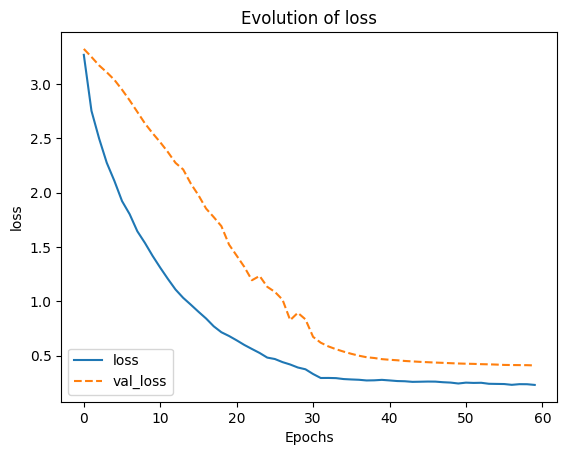

In [15]:
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.plot(classification_history.history['loss'], label='loss')
plt.plot(classification_history.history['val_loss'], linestyle='dashed', label='val_loss')


plt.legend(loc='lower left')
plt.title('Evolution of loss')
plt.show()

Test the effectiveness of the pretraining

In [16]:
evaluation1 = classification_model_cwru_pretrained.evaluate(ds_test_ft)

print("Evaluation accuracy with pretraining on encoder: {:.2f}%".format(evaluation1[1]*100))

13873/13873 ━━━━━━━━━━━━━━━━━━━━ 342s 25ms/step - accuracy: 0.9120 - loss: 0.4133
Evaluation accuracy with pretraining on encoder: 90.67%


Fine-tuning

In [17]:
# Unfreeze the encoder weights
simclr_model.encoder.trainable = True

classification_model_cwru_pretrained.compile(
    optimizer=keras.optimizers.Adam(1e-5), 
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,       
    restore_best_weights=True  
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,         
    patience=2          
)

classification_history1 = classification_model_cwru_pretrained.fit(
    ds_train_ft.repeat(), 
    epochs=50, 
    validation_data=ds_val_ft, 
    steps_per_epoch=int((0.1*ds_test_size) // batch_size),
    callbacks=[early_stopping, reduce_lr])


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 511ms/step - accuracy: 0.9651 - loss: 0.2536 - val_accuracy: 0.9193 - val_loss: 0.3860 - learning_rate: 1.0000e-05
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 497ms/step - accuracy: 0.9827 - loss: 0.2138 - val_accuracy: 0.9245 - val_loss: 0.3657 - learning_rate: 1.0000e-05
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 450ms/step - accuracy: 0.9821 - loss: 0.1938 - val_accuracy: 0.9297 - val_loss: 0.3489 - learning_rate: 1.0000e-05
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 528ms/step - accuracy: 0.9875 - loss: 0.1714 - val_accuracy: 0.9297 - val_loss: 0.3340 - learning_rate: 1.0000e-05
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 438ms/step - accuracy: 0.9881 - loss: 0.1685 - val_accuracy: 0.9258 - val_loss: 0.3212 - learning_rate: 1.0000e-05
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 477ms/step - accuracy: 0.9917 - loss: 0.1624 - val_accuracy: 0.9323 - val_loss: 0.3100 - learning_rate: 1.0000e-05
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 473ms/step - accu

Evaluate the model 

In [18]:
evaluation1 = classification_model_cwru_pretrained.evaluate(ds_test_ft)

print("Evaluation accuracy with pretraining on encoder: {:.2f}%".format(evaluation1[1]*100))

    1/13873 ━━━━━━━━━━━━━━━━━━━━ 12:19 53ms/step - accuracy: 1.0000 - loss: 0.0198

13873/13873 ━━━━━━━━━━━━━━━━━━━━ 373s 27ms/step - accuracy: 0.9692 - loss: 0.1469
Evaluation accuracy with pretraining on encoder: 96.53%


In [19]:
encoder = Encoder(input_shape,n_embedding,kernel_size)

simclr_model = SimCLRModel(encoder)

# Freeze the encoder weights
simclr_model.encoder.trainable = False

classification_head_ft= keras.Sequential([
    layers.Input(shape=(n_embedding,)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(len(lb1)) #nb labels
], name='Classification_head')

# Create a new classification model
encoder_output = simclr_model.encoder(simclr_model.encoder.layers[0].input, training=False)
simclr_model_not_pretrained = keras.Model(
    inputs=simclr_model.encoder.layers[0].input,
    outputs=classification_head_ft(encoder_output)
)

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,       
    restore_best_weights=True  
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,         
    patience=2          
)

simclr_model_not_pretrained.compile(
    optimizer=keras.optimizers.Adam(), 
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy'])

classification_history = simclr_model_not_pretrained.fit(
    ds_train_ft.repeat(), 
    epochs=60, 
    validation_data=ds_val_ft, 
    steps_per_epoch=int((0.1*ds_test_size) // batch_size),
)

Epoch 1/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 335ms/step - accuracy: 0.0629 - loss: 3.4001 - val_accuracy: 0.0742 - val_loss: 3.3390
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 340ms/step - accuracy: 0.1775 - loss: 2.9924 - val_accuracy: 0.1445 - val_loss: 3.3043
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 337ms/step - accuracy: 0.2572 - loss: 2.7061 - val_accuracy: 0.1654 - val_loss: 3.2642
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 341ms/step - accuracy: 0.3275 - loss: 2.4490 - val_accuracy: 0.1914 - val_loss: 3.2196
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 339ms/step - accuracy: 0.3917 - loss: 2.2476 - val_accuracy: 0.2318 - val_loss: 3.1745
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 341ms/step - accuracy: 0.4560 - loss: 2.0678 - val_accuracy: 0.2227 - val_loss: 3.1305
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 339ms/step - accuracy: 0.5171 - loss: 1.9121 - val_accuracy: 0.1901 - val_loss: 3.0875
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 339ms/step - accuracy: 0.6034 - loss: 1.7431 - val_accuracy: 0.

In [20]:
evaluation1 = simclr_model_not_pretrained.evaluate(ds_test_ft)

print("Evaluation accuracy with pretraining on encoder: {:.2f}%".format(evaluation1[1]*100))

13873/13873 ━━━━━━━━━━━━━━━━━━━━ 297s 21ms/step - accuracy: 0.7675 - loss: 0.7493
Evaluation accuracy with pretraining on encoder: 77.25%
